In [79]:
import mindspore
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from mindspore import nn, Tensor
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset
from mindspore import dtype as mstype

In [4]:
# mnist_dir = r"./datasets_/mnist_dataset/MNIST/raw"
# mnist_path = os.path.normpath(os.path.join(os.getcwd(), mnist_dir))  
# # D:\ddesktop\人工智能程序设计\IPython_\datasets_\mnist_dataset\MNIST\raw
# # print(mnist_path)
# print(os.listdir(mnist_path))

In [80]:
mnist_train = r"./datasets_/mindspore_mnist/train"
mnist_test = r"./datasets_/mindspore_mnist/test"
train_dataset = MnistDataset(mnist_train)  
test_dataset =  MnistDataset(mnist_test)  

In [86]:
train_dataset.output_shapes() 
# [[28, 28, 1], []]

[[28, 28, 1], []]

In [84]:
# # 看路径中的中文字符是否会引发异常，runtimeError
# data_dir_ = os.path.normpath(os.path.join(os.getcwd(), mnist_train))
# # print(data_dir_)
# # # D:\ddesktop\人工智能程序设计\IPython_\datasets_\mindspore_mnist\train
# ds_ = MnistDataset(mnist_train)
# ds_.output_shapes() 

[[28, 28, 1], []]

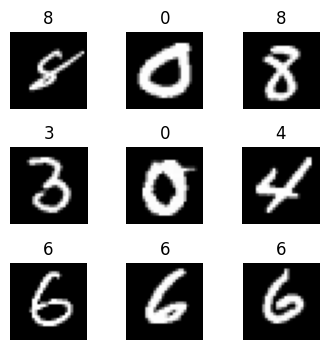

In [88]:
def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3

    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()

visualize(train_dataset)

数据变换
通常情况下，直接加载的原始数据并不能直接送入神经网络进行训练，此时我们需要对其进行数据预处理。MindSpore提供不同种类的数据变换（Transforms），配合数据处理Pipeline来实现数据预处理，所有的Transforms均可通过.map(...)方法传入。

.map(...)操作可以针对数据集指定列（column）添加数据变换（Transforms），将数据变换应用于该列数据的每个元素，并返回包含变换后元素的新数据集。

.map(...)操作可以执行Dataset模块提供的内置数据变换操作，也可以执行用户自定义的变换操作。

mindspore.dataset提供了面向图像、文本、音频等不同数据类型的内置数据变换操作，同时也支持使用自定义数据变换操作。

下面举例对Mnist数据集中data使用 Rescale、Normalize和HWC2CHW操作，对label使用TypeCast操作。

Rescale：用于调整图像像素值的大小，包括两个参数：rescale（缩放因子）和shift（平移因子），图像的每个像素将根据这两个参数进行调整，输出的像素值为
。

Normalize：用于对输入图像的归一化，包括三个参数：mean（图像每个通道的均值）、std（图像每个通道的标准差）和is_hwc（bool值，输入图像的格式。True为(height, width, channel)，False为(channel, height, width)）。

HWC2CHW：用于转换图像格式，将图像从HWC转换成CHW。


In [89]:
train_dataset = train_dataset.map(operations=[vision.Rescale(1.0 / 255.0, 0),
                                              vision.Normalize(mean=(0.1307,), std=(0.3081,)),
                                              vision.HWC2CHW()],
                                  input_columns=['image'])
train_dataset = train_dataset.map(operations=[transforms.TypeCast(mstype.int32)],
                                  input_columns=['label'])
for data in train_dataset:
    print(data[0].shape, data[0].dtype)
    print(data[1].shape, data[1].dtype)
    break

(1, 28, 28) Float32
() Int32


In [90]:
class LeNet(nn.Cell):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, pad_mode='same')
        # 激活函数
        self.act1 = nn.ReLU()
        # 最大池化
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, pad_mode='valid')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 展平
        self.flat = nn.Flatten()
        # 全连接层
        self.fc1 = nn.Dense(16*5*5, 120)
        self.act3 = nn.ReLU()
        
        self.fc2 = nn.Dense(120, 84)
        self.act4 = nn.ReLU()
        
        self.fc3 = nn.Dense(84, num_classes)
        
    def construct(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.pool2(self.act2(self.conv2(x)))
        
        x = self.flat(x)
        
        x = self.act3(self.fc1(x))
        
        x = self.act4(self.fc2(x))
        
        x = self.fc3(x)
        return x
 

In [91]:
ms_model = LeNet()
print(ms_model)

LeNet<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x000002512CFFE670>, bias_init=None, format=NCHW>
  (act1): ReLU<>
  (pool1): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x000002512CFFEA30>, bias_init=None, format=NCHW>
  (act2): ReLU<>
  (pool2): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flat): Flatten<>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (act3): ReLU<>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (act4): ReLU<>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  >


In [92]:
print(f"Model structure: {ms_model}\n\n")

for name, param in ms_model.parameters_and_names():
    # print(f"Layer: {name}\nSize: {param.shape}\nValues : {param[:2]} \n")
    print(f"Layer: {name}\nSize: {param.shape}\n")


Model structure: LeNet<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x000002512CFFE670>, bias_init=None, format=NCHW>
  (act1): ReLU<>
  (pool1): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x000002512CFFEA30>, bias_init=None, format=NCHW>
  (act2): ReLU<>
  (pool2): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flat): Flatten<>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (act3): ReLU<>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (act4): ReLU<>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  >


Layer:

In [94]:
def datapipe(path, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = MnistDataset(path)
    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset


# mnist_train = r"./datasets_/mindspore_mnist/train"
# mnist_test = r"./datasets_/mindspore_mnist/test"
train_loader = datapipe(mnist_train, batch_size=32)
test_loader = datapipe(mnist_test, batch_size=32)

In [95]:
epochs = 3
batch_size = 32
learning_rate = 1e-3
 
loss_fn = nn.CrossEntropyLoss()

optimizer = nn.SGD(ms_model.trainable_params(), learning_rate=learning_rate)


# 保存模型权重
model_save = r"./logs_dir/lenet_mindspore"
os.makedirs(model_save, exist_ok=True)
model_save_path = os.path.normpath(os.path.join(model_save, "best_mindspore_lenet.ckpt"))

# 定义前向传播函数
def forward_fn(data, label):
    outs = ms_model(data)
    loss = loss_fn(outs, label)
    return loss, outs

# 获取梯度的函数，传入optimizer
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_loop(model, data_loader):
    size = data_loader.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(data_loader.create_tuple_iterator()):
        loss = train_step(data, label)
        
        if batch%100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

def test_loop(model, data_loader, loss_fn, best_test_acc=0.0):
    num_batches = data_loader.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in data_loader.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    # save best model
    if correct > best_test_acc:
        best_test_acc = correct
        mindspore.save_checkpoint(ms_model, model_save_path)
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [96]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(ms_model, train_loader)
    test_loop(ms_model, test_loader, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.315099  [  0/1875]
loss: 2.311205  [100/1875]
loss: 2.315240  [200/1875]
loss: 2.292525  [300/1875]
loss: 2.286823  [400/1875]
loss: 2.297560  [500/1875]
loss: 2.310534  [600/1875]
loss: 2.285043  [700/1875]
loss: 2.290683  [800/1875]
loss: 2.284361  [900/1875]
loss: 2.276896  [1000/1875]
loss: 2.281837  [1100/1875]
loss: 2.274083  [1200/1875]
loss: 2.258741  [1300/1875]
loss: 2.257386  [1400/1875]
loss: 2.246572  [1500/1875]
loss: 2.254220  [1600/1875]
loss: 2.245849  [1700/1875]
loss: 2.216790  [1800/1875]
Test: 
 Accuracy: 40.1%, Avg loss: 2.210162 

Epoch 2
-------------------------------
loss: 2.194929  [  0/1875]
loss: 2.178500  [100/1875]
loss: 2.144861  [200/1875]
loss: 2.105261  [300/1875]
loss: 2.092807  [400/1875]
loss: 2.068809  [500/1875]
loss: 2.021101  [600/1875]
loss: 1.892331  [700/1875]
loss: 1.749285  [800/1875]
loss: 1.669093  [900/1875]
loss: 1.511461  [1000/1875]
loss: 1.371332  [1100/1875]
loss: 1.120261  [1200/1875

加载权重，推理测试

In [97]:
infer_model = LeNet()
param_dict = mindspore.load_checkpoint(model_save_path)
mindspore.load_param_into_net(infer_model, param_dict)

([], [])

In [98]:
from PIL import Image
import numpy as np
from mindspore import Tensor
img_path = r"./datasets_/write_mnist/9.png"
image = Image.open(img_path).convert('L').resize((28,28))
image_np = np.array(image).reshape([1,1,28,28]) 
image_tensor = Tensor.from_numpy(image_np).astype(mindspore.float32)

infer_model.set_train(False)  # 设置模型为推理模式
outs = infer_model(image_tensor)[0].argmax().asnumpy()
print(outs)

0


### 解析MNIST，然后构建标准模式的mindspore数据集

In [99]:
import mindspore
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from mindspore import nn, Tensor
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset
from mindspore import dtype as mstype

In [100]:
# 自定义的mindspore标准格式数据集
from mindspore.mindrecord import FileWriter
import struct
# 解析ubyte文件，读取图片和标签  ./datasets_/
def parse_ubyte(ubyte, gen=False):
    if ubyte == "train":
        img_file = r"./datasets_/mindspore_mnist/train/train-images-idx3-ubyte"
        lbl_file = r"./datasets_/mindspore_mnist/train/train-labels-idx1-ubyte"
        label_file = open("parse_mnist/train_labels.txt", 'w')
        img_dir = "parse_mnist/train_images"
        if gen:
            os.makedirs(img_dir, exist_ok=True)
    elif ubyte == "test":
        img_file = r"./datasets_/mindspore_mnist/test/t10k-images-idx3-ubyte"
        lbl_file = r"./datasets_/mindspore_mnist/test/t10k-labels-idx1-ubyte"
        label_file = open("parse_mnist/test_labels.txt", 'w') 
        img_dir = "parse_mnist/test_images"
        if gen:
            os.makedirs(img_dir, exist_ok=True)
    else:
        print("输入ubyte不对")
        return None
    

    # 读取图片文件
    with open(img_file, 'rb') as f:
        # 读取文件头
        magic_number = struct.unpack('>I', f.read(4))[0]  # Magic number
        assert magic_number == 2051, f"{magic_number} Image file magic number incorrect!"
        
        num_images = struct.unpack('>I', f.read(4))[0]  # 读取图片数量
        rows = struct.unpack('>I', f.read(4))[0]  # 读取图片的行数
        cols = struct.unpack('>I', f.read(4))[0]  # 读取图片的列数
        print(f"num_images={num_images}, rows={rows}, cols={cols}")
        
        # 确保读取的字节数量与图片数据匹配
        image_data = np.fromfile(f, dtype=np.uint8)
        expected_size = num_images * rows * cols
        assert image_data.size == expected_size, f"Expected {expected_size} bytes, but got {image_data.size} bytes."
        
        # 将数据reshape为(num_images, rows, cols)
        images = image_data.reshape(num_images, rows, cols)

    # 读取标签文件
    with open(lbl_file, 'rb') as f:
        # 读取文件头
        magic_number = struct.unpack('>I', f.read(4))[0]  # Magic number
        assert magic_number == 2049, f"{magic_number} Label file magic number incorrect!"
        
        num_labels = struct.unpack('>I', f.read(4))[0]  # 读取标签数量
        labels_data = np.fromfile(f, dtype=np.uint8)  # 读取标签数据
        assert len(labels_data) == num_labels, f"Expected {num_labels} labels, but got {len(labels_data)} labels."
        
        labels = labels_data  # 保存标签数据

    # 如果gen=True，生成图片和标签文件
    if gen:
        for i in range(num_images):
            img = Image.fromarray(images[i])  # 将图片数据转换为PIL图片对象
            img.save(os.path.join(img_dir, f"{i+1}.jpg"))  # 保存图片为jpg文件
            label_file.write(f"{i+1}.jpg {labels[i]}\n")  # 写入标签文件

    label_file.close()
    # print(images.size, labels.size)
    return images, labels

# ## use
# parse_ubyte('train', gen=False)
# parse_ubyte('test', gen=True)


# def check_magic_number(file_path):
#     with open(file_path, 'rb') as f:
#         # 读取文件前4个字节（魔术数字应该在这4个字节中）
#         # magic_number = np.fromfile(f, dtype=np.uint32, count=1)[0]
#         magic_number = np.fromfile(f, dtype=np.dtype('>u4'), count=1)
#         print(f"Magic number: {magic_number}")
# train_img = r"./datasets_/mindspore_mnist/train/train-images-idx3-ubyte"
# # check_magic_number(train_img)


In [ ]:
# !python -m pip install tqdm

In [101]:
import tqdm
from mindspore.mindrecord import FileWriter
# 获取mindrecord格式数据集
def get_my_msrecord(mode, target_root= "parse_mnist/msrecord"):
    os.makedirs(target_root, exist_ok=True)
    
    if mode == "train":
        # 创建 MindRecord 文件路径
        mindrecord_path = os.path.join(target_root, 'train.mindrecord')
    elif mode == "test":
        # 创建 MindRecord 文件路径
        mindrecord_path = os.path.join(target_root, 'test.mindrecord')
    else:
        print("error input")
        return 
    
    writers = FileWriter(mindrecord_path, 32)  # 32 is the batch size
    
    # 构建字段
    schema = {
        "file_name": {"type": "string"},
        "label": {"type": "int32"},
        "data": {"type": "bytes"}}
    
    # 设置文件格式
    if mode == "train":
        writers.add_schema(schema, "train_schema")
        train_imgs, train_lbls = parse_ubyte(mode, False)
        print(train_imgs.size, train_lbls.size)
        # 写入训练集数据
        for i in tqdm.tqdm(range(len(train_imgs))):
            sample = {
                "file_name": f"train_{i}.jpg",
                "label": int(train_lbls[i]),
                "data": train_imgs[i].tobytes()  # 将图片数据转换为字节格式
            }
            writers.write_raw_data([sample])
    else:
        writers.add_schema(schema, "test_schema")
        test_imgs, test_lbls = parse_ubyte(mode, False)
        # 写入测试集数据
        for i in tqdm.tqdm(range(len(test_imgs))):
            sample = {
                "file_name": f"test_{i}.jpg",
                "label": int(test_lbls[i]),
                "data": test_imgs[i].tobytes()
            }
            writers.write_raw_data([sample])
    
    # 关闭文件
    writers.commit()

    print(f"MindRecord files created at {target_root}")

# get_my_msrecord("train")
# get_my_msrecord("test")

In [103]:
from mindspore.dataset import MindDataset
import io

def file_test(file_list):
    for f in file_list:
        if not os.path.isfile(f):
            print(f)
            break


# 读取并打印数据集中的样本信息
def load_mindrecord_dataset(target_root, mode, batch_size=32):
    # 构造文件路径：train 或 test 数据集
    if mode == "train":
        mindrecord_files = [os.path.join(target_root,file) for file in os.listdir(target_root) if file.startswith('train.') and not file.endswith('.db')]  
        # print(mindrecord_files)
    elif mode == "test":
        mindrecord_files = [os.path.join(target_root,file) for file in os.listdir(target_root) if file.startswith('test.') and not file.endswith('.db')]
    else:
        print("Error: Invalid mode!")
        return

    file_test(mindrecord_files)  # pass 
    
    # 加载 MindRecord 数据集，自动处理多个分片文件
    dataset = MindDataset(mindrecord_files)

    # 设置批次大小
    dataset = dataset.batch(batch_size)
    
    # 打印数据集的一些基本信息（如字段名和数据形状）
    for data in dataset.create_dict_iterator():
        print(f"Data sample:")
        for key, value in data.items():
            print(f"  {key} shape: {value.shape if hasattr(value, 'shape') else 'No shape'}")
            # data: (32, 1)  file_name: (32,)  label: (32,)
            if key == "data":
                # print(f"  {key} sample: {value.size}")
                image_StubTensor = data['data']  # mindspore将字节码解析成StubTensor
                numpy_imgs = image_StubTensor.asnumpy()  
                # numpy_imgs.shape=(32, 1)  dtype='|S784'
                decoded_images = np.array(
                    [np.frombuffer(img, dtype=np.uint8).reshape(28, 28) 
                    for img in numpy_imgs])
                # decoded_images.shape=(32, 28, 28)  # b h w
                for i in range(decoded_images.shape[0]):
                    np_image = decoded_images[i]   
                    # print(f"{np_image.shape=}")  # np_image.shape=(28, 28)
                    label = data['label'][i].asnumpy()   # 获取标签（数字形式）
                    file_name = data['file_name'][i]
                    image = Image.fromarray(np_image) 
                    # print(f"{image.size=}")  # image.size=(28, 28)
                    image.convert("L").show()
                    break

        break  # 只打印第一个样本的结构，避免输出过多内容

    return dataset


# 示例：读取数据集并打印样本信息
mindrecord_path = r".\parse_mnist\msrecord" 
load_mindrecord_dataset(mindrecord_path, mode='train')


Data sample:
  data shape: (32, 1)
  file_name shape: (32,)
  label shape: (32,)
